In [1]:
import os 

In [2]:
path,dir1,files=next(os.walk("Brain_Data_Organised/Train/Stroke"))
print(f"stocke :{len(files)}")
path,dir1,files=next(os.walk("Brain_Data_Organised/Train/Normal"))
print(f" non stocke :{len(files)}")

stocke :950
 non stocke :1426


In [3]:
import tensorflow as tf

train=tf.keras.preprocessing.image_dataset_from_directory(
    "Brain_Data_Organised/Train",
    subset="training",
    seed=1337,
    validation_split=0.20,image_size=(224,224),
    batch_size=16


)
val=tf.keras.preprocessing.image_dataset_from_directory(
     "Brain_Data_Organised/Train",
    subset="validation",
    validation_split=0.20,
    batch_size=16
    ,image_size=(224,224),
    seed=333,shuffle=True

)

test = tf.keras.preprocessing.image_dataset_from_directory(
    "Brain_Data_Organised/Test",
    image_size=(224,224),
    batch_size=16,
    shuffle=False,
)
    
    


Found 2376 files belonging to 2 classes.
Using 1901 files for training.
Found 2376 files belonging to 2 classes.
Using 475 files for validation.
Found 250 files belonging to 2 classes.


In [4]:
import numpy as np
y_true=np.concatenate([y for x,y in test],axis=0)

In [5]:
train=train.prefetch(buffer_size=32)
val=val.prefetch(buffer_size=32)

In [6]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint


def get_callbacks(model_name):
    callbacks=[]
    check_point=ModelCheckpoint(filepath=f"mode2l.{model_name}.h5",mode="min",monitor="val_loss",save_best_only=True)
    callbacks.append(check_point)
    reduce=ReduceLROnPlateau(monitor="val_loss",patience=6,min_delta=0.00001,mode="auto",min_lr=0.0000001)
    callbacks.append(reduce)
    earlystop = EarlyStopping(monitor='loss', patience=10)
    callbacks.append(earlystop)
    return callbacks

In [7]:
from keras.layers import GlobalAveragePooling2D,Dense
from keras.models import Model
from keras .metrics import Precision,Recall
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
from keras.applications import DenseNet121

model=DenseNet121(include_top=False,weights="imagenet",input_shape=(224,224,3))
for layer in model.layers[350:]:
    layer.trainable=True

x=model.output
x=GlobalAveragePooling2D()(x)
final_layer=Dense(1,activation="sigmoid",name="final")(x)
model_final=Model(inputs=model.input,outputs=final_layer)

OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model_final.compile(optimizer="Adam",loss="binary_crossentropy",metrics=["accuracy",Precision(),Recall()])


In [8]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [9]:
print(len(model_final.layers))

429


In [12]:
call=get_callbacks("dense121")
hist=model_final.fit(train,epochs=50,callbacks=[call],validation_data=val)

Epoch 1/50
119/119 [==============================] - 560s 4s/step - loss: 0.5597 - accuracy: 0.7223 - precision: 0.6638 - recall: 0.6074 - val_loss: 3.8273 - val_accuracy: 0.5663 - val_precision: 0.4909 - val_recall: 0.8100 - lr: 0.0010
Epoch 2/50
119/119 [==============================] - 509s 4s/step - loss: 0.3961 - accuracy: 0.8180 - precision: 0.7841 - recall: 0.7467 - val_loss: 0.6337 - val_accuracy: 0.8358 - val_precision: 0.8466 - val_recall: 0.7450 - lr: 0.0010
Epoch 3/50
119/119 [==============================] - 475s 4s/step - loss: 0.2825 - accuracy: 0.8837 - precision: 0.8759 - recall: 0.8236 - val_loss: 0.8186 - val_accuracy: 0.7916 - val_precision: 0.8061 - val_recall: 0.6650 - lr: 0.0010
Epoch 4/50
119/119 [==============================] - 490s 4s/step - loss: 0.2164 - accuracy: 0.9132 - precision: 0.8964 - recall: 0.8833 - val_loss: 0.1469 - val_accuracy: 0.9432 - val_precision: 0.9943 - val_recall: 0.8700 - lr: 0.0010
Epoch 5/50
119/119 [============================

In [8]:
import matplotlib.pyplot as plt

def visulaization_ACC_loss_VL_Valloss(model_name,name):
     print(name)

     acc = model_name.history['accuracy']
     val_acc = model_name.history['val_accuracy']
     loss = model_name.history['loss']
     val_loss = model_name.history['val_loss']
     epochs = range(1, len(acc) + 1)

     plt.plot(epochs, acc, label='Training accurarcy')
     plt.plot(epochs, val_acc, label='Validation accurarcy')
     plt.title('Training and Validation accurarcy')
     plt.xlabel('Epochs')
     plt.ylabel('Accuracy')
     plt.legend()

     plt.figure()

     plt.plot(epochs, loss,  label='Training loss')
     plt.plot(epochs, val_loss, label='Validation loss')
     plt.title('Training and Validation loss')
     plt.xlabel('Epochs')
     plt.ylabel('Loss')
     plt.legend()
     plt.show()

dense121


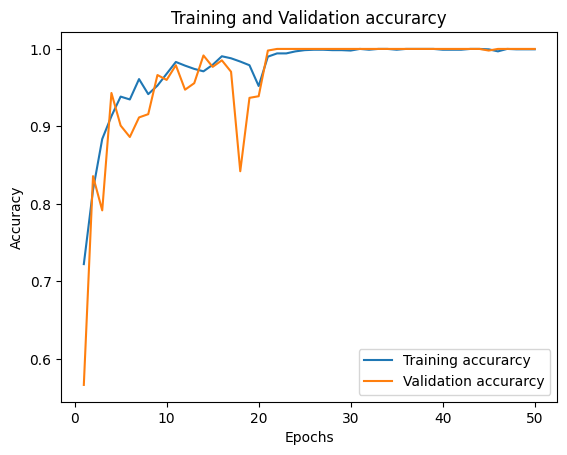

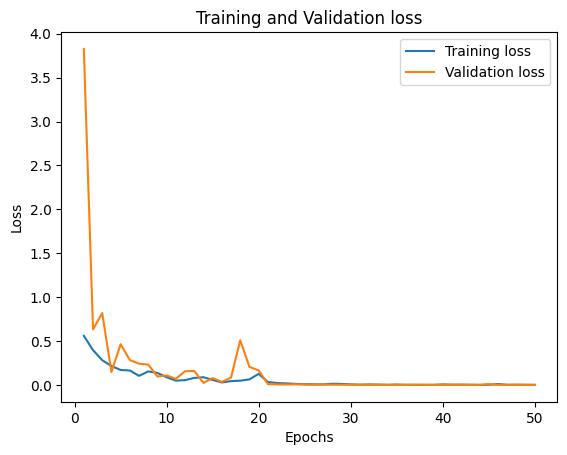

In [14]:
visulaization_ACC_loss_VL_Valloss(hist,"dense121")

In [ ]:
from keras.models import load_model
model =load_model('mode2l.dense121.h5')
model.evaluate(test)


16/16 [==============================] - 15s 694ms/step - loss: 0.1619 - accuracy: 0.9800 - precision: 0.9688 - recall: 0.9920


[0.16192248463630676, 0.9800000190734863, 0.96875, 0.9919999837875366]

In [16]:
y_pred=model.predict(test).round()
y_pred=y_pred.flatten()

16/16 [==============================] - 12s 578ms/step


In [10]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
target_names=["stocke "," non stocke"]
def evaluation(y_true,y_pred):
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
    disp = confusion_matrix(y_true, y_pred)
    disp.astype('int')
    pd.options.display.float_format = '{:.5f}'.format
    df_cm = pd.DataFrame(disp, target_names, target_names)

    fig, ax = plt.subplots(figsize=(4,4))
    
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 15},ax=ax, cmap="YlOrBr" , fmt='g',cbar=False) # font size
    plt.ylabel('Actual',fontsize=20)
    plt.xlabel('Predicted',fontsize=20)
    plt.ioff()
    plt.savefig("confusion_mat", bbox_inches='tight')

              precision    recall  f1-score   support

     stocke      0.9918    0.9680    0.9798       125
  non stocke     0.9688    0.9920    0.9802       125

    accuracy                         0.9800       250
   macro avg     0.9803    0.9800    0.9800       250
weighted avg     0.9803    0.9800    0.9800       250



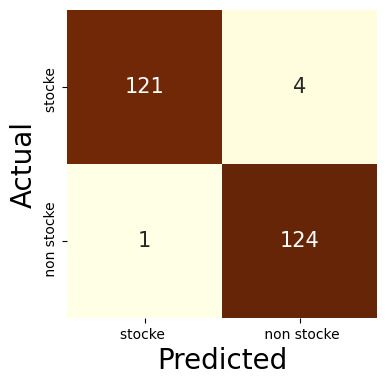

In [18]:
evaluation(y_true,y_pred)

In [9]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:


base_model=tf.keras.applications.ResNet50(include_top=False,input_shape=(224,224,3),weights="imagenet")

for layer in base_model.layers[100:]:
    layer.trainable=True

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1,activation="sigmoid",name="Final")(x)
model=Model(inputs=base_model.input,outputs=x)
model.compile(loss="binary_crossentropy",optimizer=OPTIMIZER,metrics=["accuracy",Precision(),Recall()])

In [20]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [21]:
print(len(model_final.layers))

429


In [23]:
callbacks = get_callbacks('resnet50')
hist = model.fit( train,epochs=26,
                    validation_data= val,
                    callbacks=[callbacks])

Epoch 1/26
119/119 [==============================] - 126s 1s/step - loss: 0.0797 - accuracy: 0.9726 - precision_1: 0.9718 - recall_1: 0.9589 - val_loss: 0.8807 - val_accuracy: 0.8274 - val_precision_1: 1.0000 - val_recall_1: 0.5900 - lr: 0.0010
Epoch 2/26
119/119 [==============================] - 122s 1s/step - loss: 0.1051 - accuracy: 0.9616 - precision_1: 0.9570 - recall_1: 0.9456 - val_loss: 0.0478 - val_accuracy: 0.9832 - val_precision_1: 0.9898 - val_recall_1: 0.9700 - lr: 0.0010
Epoch 3/26
119/119 [==============================] - 119s 999ms/step - loss: 0.0421 - accuracy: 0.9853 - precision_1: 0.9840 - recall_1: 0.9788 - val_loss: 0.0803 - val_accuracy: 0.9705 - val_precision_1: 1.0000 - val_recall_1: 0.9300 - lr: 0.0010
Epoch 4/26
119/119 [==============================] - 123s 1s/step - loss: 0.0271 - accuracy: 0.9916 - precision_1: 0.9920 - recall_1: 0.9867 - val_loss: 0.0349 - val_accuracy: 0.9874 - val_precision_1: 0.9802 - val_recall_1: 0.9900 - lr: 0.0010
Epoch 5/26
11

resnet50


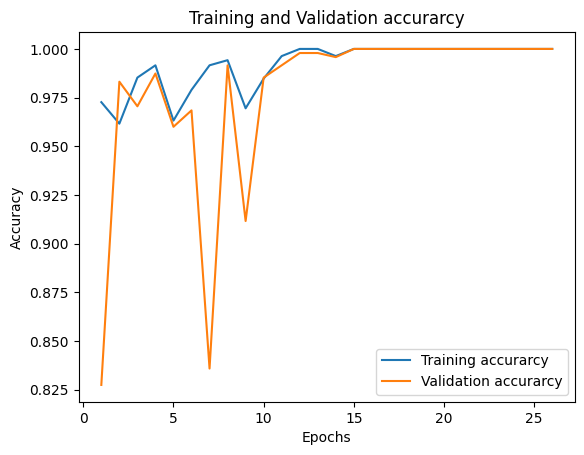

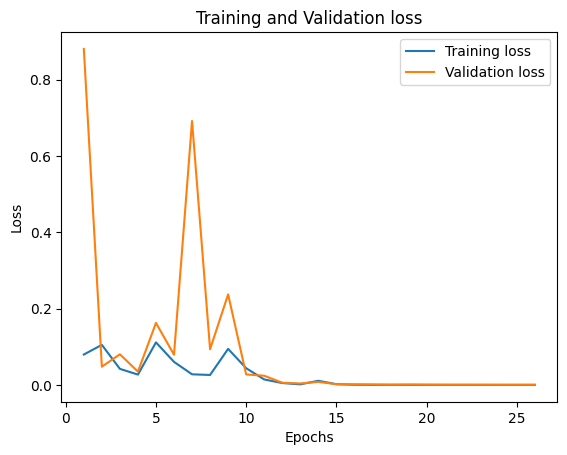

In [24]:
visulaization_ACC_loss_VL_Valloss(hist,"resnet50")

In [ ]:
from keras.models import load_model
model =load_model('mode2l.resnet50.h5')
model.evaluate(test, steps=len(test), verbose=1)

16/16 [==============================] - 9s 472ms/step - loss: 0.3085 - accuracy: 0.9320 - precision_2: 0.8857 - recall_2: 0.9920


[0.3085278570652008,
 0.9319999814033508,
 0.8857142925262451,
 0.9919999837875366]

In [27]:
y_pred=model.predict(test).round()
y_pred=y_pred.flatten()

16/16 [==============================] - 7s 375ms/step


In [28]:
evaluation(y_true,y_pred)

              precision    recall  f1-score   support

     stocke      0.9909    0.8720    0.9277       125
  non stocke     0.8857    0.9920    0.9358       125

    accuracy                         0.9320       250
   macro avg     0.9383    0.9320    0.9318       250
weighted avg     0.9383    0.9320    0.9318       250



In [11]:
base_model=tf.keras.applications.xception.Xception(include_top=False,weights="imagenet",input_shape=(224,224,3))
for layer in base_model.layers[100:]:
    layer.trainable=True
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1,activation="sigmoid",name="Final")(x)
model=Model(inputs=base_model.input,outputs=x)
model.compile(loss ='binary_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy',Precision(), Recall()])

In [12]:
callbacks = get_callbacks('Xception')
hist2= model.fit( train,epochs=27,
                    validation_data= val,
                    callbacks=[callbacks])

Epoch 1/27
119/119 [==============================] - 330s 2s/step - loss: 0.6140 - accuracy: 0.6696 - precision: 0.6486 - recall: 0.3647 - val_loss: 0.9606 - val_accuracy: 0.7284 - val_precision: 0.7840 - val_recall: 0.4900 - lr: 0.0010
Epoch 2/27
119/119 [==============================] - 263s 2s/step - loss: 0.4146 - accuracy: 0.8211 - precision: 0.8017 - recall: 0.7294 - val_loss: 0.9602 - val_accuracy: 0.8611 - val_precision: 0.8564 - val_recall: 0.8050 - lr: 0.0010
Epoch 3/27
119/119 [==============================] - 267s 2s/step - loss: 0.2210 - accuracy: 0.9111 - precision: 0.8937 - recall: 0.8806 - val_loss: 0.1360 - val_accuracy: 0.9621 - val_precision: 0.9643 - val_recall: 0.9450 - lr: 0.0010
Epoch 4/27
119/119 [==============================] - 259s 2s/step - loss: 0.1610 - accuracy: 0.9400 - precision: 0.9278 - recall: 0.9204 - val_loss: 0.1746 - val_accuracy: 0.9411 - val_precision: 1.0000 - val_recall: 0.8600 - lr: 0.0010
Epoch 5/27
119/119 [============================

Xception


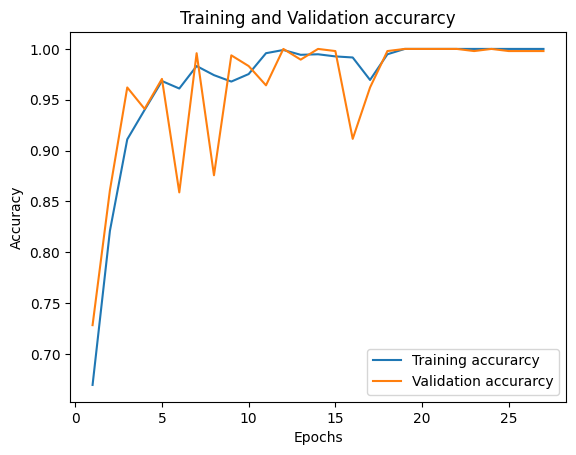

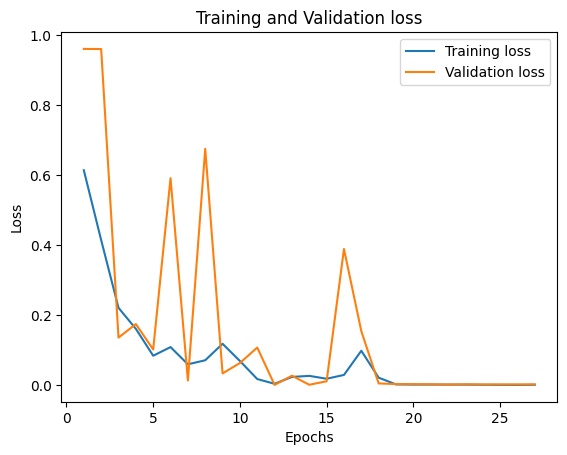

In [13]:
visulaization_ACC_loss_VL_Valloss(hist2,"Xception")

In [15]:
from keras.models import load_model

In [16]:
model = load_model('mode2l.Xception.h5')
model.evaluate(test, steps=len(test), verbose=1)

16/16 [==============================] - 11s 610ms/step - loss: 0.1419 - accuracy: 0.9640 - precision: 0.9394 - recall: 0.9920


[0.1418854147195816, 0.9639999866485596, 0.939393937587738, 0.9919999837875366]

In [17]:
y_pred=model.predict(test).round()
y_pred=y_pred.flatten()

16/16 [==============================] - 10s 521ms/step


              precision    recall  f1-score   support

     stocke      0.9915    0.9360    0.9630       125
  non stocke     0.9394    0.9920    0.9650       125

    accuracy                         0.9640       250
   macro avg     0.9655    0.9640    0.9640       250
weighted avg     0.9655    0.9640    0.9640       250



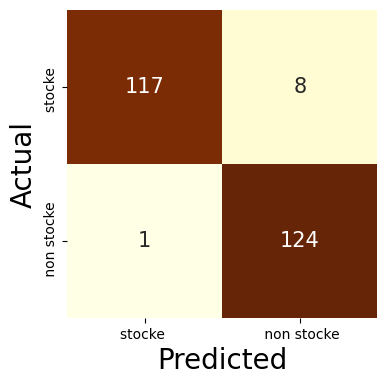

In [18]:
evaluation(y_true,y_pred)